In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
from scipy import optimize
from pylab import *


In [23]:
path = '/srv/home/chenyu/DEbackup/072419/S10/'

# Load COM file
# COM = np.load(path + 'COM.npy')
# COM_exp_mag = np.sqrt(COM[:,:,0]**2 + COM[:,:,1]**2)

# Load HAADF file
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))
# HAADFarray = HAADFarray[100:150,:]

HAADFarray_gauss = scipy.ndimage.gaussian_filter(HAADFarray,1)

# Refine positions of peaks
im = img_as_float(HAADFarray_gauss,(150,150))
image_max = ndi.maximum_filter(im, size=5, mode='constant')
coordinates = peak_local_max(im, min_distance=5)

peaks_x_fit = []
peaks_y_fit = []
for i in range(coordinates.shape[0]):
    
    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    
    if x >=7 and y>=7:
        patch = im[y-4:y+4,x-4:x+4]
        patch = patch - amin(patch)
        bg = 0

        # parameters are in the order of : background, height, cx, cy, wx, wy
        guess = (bg,patch[4,4]-bg,4, 4, 3, 3)
        bounds = ([0,0,0,0,1,1],[np.inf,np.inf,8,8,10,10])
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-4)
        peaks_y_fit.append(param[3]+y-4)
    


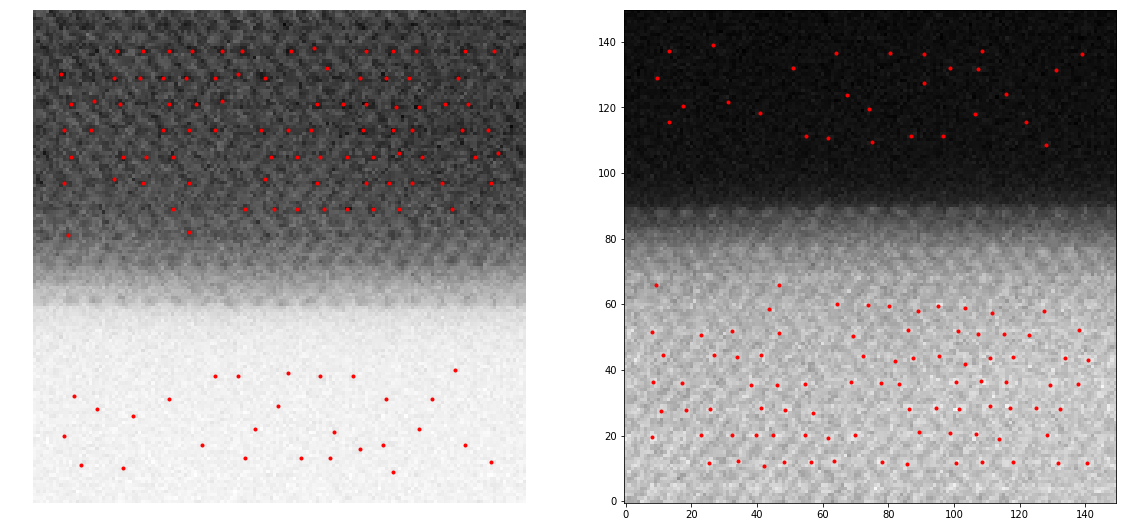

In [24]:

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.imshow(np.log(np.abs(HAADFarray)), cmap='gray')
plt.axis('off')
plt.plot(coordinates[:,1], coordinates[:,0],'r.')

fig.add_subplot(1,3,2)
plt.imshow(HAADFarray, cmap='gray',origin='lower')
# plt.axis('off')
plt.plot(peaks_x_fit, peaks_y_fit,'r.')

# fig.add_subplot(1,3,3)
# plt.imshow(voroni_idx, cmap = 'jet')

In [2]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [3]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask